# First Take on Classification: Iteration on KNN




## Imports and Function Definitions:


In [3]:
import os
import numpy as np
import pandas as pd 
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from glob import glob
import matplotlib.pyplot as plt

def summary(array):
    min_val = np.min(array)
    max_val = np.max(array)
    sd = np.std(array)
    var = np.var(array)
    mean = np.mean(array)
    median = np.median(array)
    percentile25 = np.percentile(array, 25)
    percentile50 = np.percentile(array, 50)
    percentile75 = np.percentile(array, 75)
    
    summaryDict = {"max":max_val, 'min':min_val, "mean":mean, "median":median, "SD": sd, 
                   "var":var, "25th":percentile25, "50th": percentile50, "75th":percentile75 }
    return summaryDict

print(os.getcwd())
# print(os.listdir("./corn/train"))

d:\Programming\Python_code\PrinciplesOfDS_Course\finalProject


In [4]:
# center cropping function
def center_crop(img, target_size):
    h, w = img.shape[:2]
    th, tw = target_size

    if h < th or w < tw:
        raise ValueError("Target size should be smaller than the input image size")

    x = (w - tw) // 2
    y = (h - th) // 2
    cropped_img = img[y:y+th, x:x+tw]

    return cropped_img

In [5]:
# plotting func for prediction results
def pred_class_hist(y_prediction_list):
    pred_series = pd.Series(y_prediction_list)
    ax = pred_series.value_counts().plot(kind='bar')
    plt.xlabel('Labels')    
    plt.ylabel('Count')
    plt.title('Predictions Distribution')

    for i, v in enumerate(pred_series.value_counts()):
        ax.text(x=i, y=v + 0.5, s=v, ha='center', fontsize=10)
        
    plt.show()

## Preprocessing Data: 



In [6]:
# list files 
img_folder = './corn/train/*.png'
corn = glob(img_folder)

# preprocess images: center crop and normalization 
target_size = (140,140)
croppedImages = []

for imgPth in corn:
    temp_img = cv2.imread(imgPth)
    if (temp_img.shape[0] >= target_size[0] & temp_img.shape[1] >= target_size[1]):
        croppedimg = center_crop(temp_img, target_size)
        croppedimg = (croppedimg / 255).astype(np.float32) # normalize
        croppedImages.append(croppedimg)
    else:
        resizedImg = cv2.resize(temp_img, target_size)
        resizedImg = (resizedImg / 255).astype(np.float32) # normalize
        croppedImages.append(resizedImg)

In [7]:
# Greyscale conversion and HOG feature extraction 
croppedImages_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in croppedImages]

hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for img in croppedImages_grey]

In [8]:
summary(hog_features)

{'max': 1.0,
 'min': 0.0,
 'mean': 0.12868448,
 'median': 0.1079078,
 'SD': 0.10591532,
 'var': 0.011218056,
 '25th': 0.041880153119564056,
 '50th': 0.10790780186653137,
 '75th': 0.1979237049818039}

In [9]:
hog_features[:2] # its a list of arrays. 
# sklearn is built to handle such input so long as all lists are of the same shape, which they are. 
print(len(hog_features[0]))
print(len(hog_features))

9216
14322


## Train and Tune Model:

In [10]:
# Load in label table: 
train_csv = pd.read_csv("./corn/train.csv")
print(train_csv.head())

labels = train_csv['label']
labels.head()

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


0        broken
1          pure
2        broken
3          pure
4    discolored
Name: label, dtype: object

In [11]:
# split data, train model, make predictions
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [12]:
# inspecting data to see how balanced it is
print("total value count of labels:\n", labels.value_counts(), 
      "\nTraining data value counts:\n", y_train.value_counts(),
      "\nTesting data value counts:\n", y_test.value_counts(), sep='')

total value count of labels:
pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64
Training data value counts:
pure          4678
broken        3633
discolored    1997
silkcut       1149
Name: label, dtype: int64
Testing data value counts:
pure          1159
broken         921
discolored     507
silkcut        278
Name: label, dtype: int64


In [13]:
# ratios
num_samples = len(labels)
print("pure:", round(labels.value_counts().pure/num_samples, 4))
print("broken:", round(labels.value_counts().broken/num_samples, 4))
print("discolored:", round(labels.value_counts().discolored/num_samples, 4))
print("silkcut:", round(labels.value_counts().silkcut/num_samples, 4))
print("\n")
num_samples = len(y_train)
print("pure:", round(y_train.value_counts().pure/num_samples, 4))
print("broken:", round(y_train.value_counts().broken/num_samples, 4))
print("discolored:", round(y_train.value_counts().discolored/num_samples, 4))
print("silkcut:", round(y_train.value_counts().silkcut/num_samples, 4))
print("\n")
num_samples = len(y_test)
print("pure:", round(y_test.value_counts().pure/num_samples, 4))
print("broken:", round(y_test.value_counts().broken/num_samples, 4))
print("discolored:", round(y_test.value_counts().discolored/num_samples, 4))
print("silkcut:", round(y_test.value_counts().silkcut/num_samples, 4))

pure: 0.4076
broken: 0.318
discolored: 0.1748
silkcut: 0.0996


pure: 0.4083
broken: 0.3171
discolored: 0.1743
silkcut: 0.1003


pure: 0.4045
broken: 0.3215
discolored: 0.177
silkcut: 0.097


In [14]:
# Evaluate the classifier on the test set
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

      broken     0.7500    0.0749    0.1362       921
  discolored     0.1429    0.0020    0.0039       507
        pure     0.4168    0.9914    0.5868      1159
     silkcut     0.5556    0.0180    0.0348       278

    accuracy                         0.4272      2865
   macro avg     0.4663    0.2716    0.1904      2865
weighted avg     0.4889    0.4272    0.2853      2865



In [15]:
from sklearn.metrics import accuracy_score
print(y_test)
print(y_pred)
print(y_test.value_counts())

print("Accuracy:", accuracy_score(y_test, y_pred)) # .427 ... this would be ok, but honestly I think its because the model is just predicting the most common case a lot. 

2996         broken
304         silkcut
7588         broken
7047         broken
10494          pure
            ...    
6107           pure
12606          pure
408          broken
6908           pure
1608     discolored
Name: label, Length: 2865, dtype: object
['pure' 'pure' 'pure' ... 'pure' 'pure' 'pure']
pure          1159
broken         921
discolored     507
silkcut        278
Name: label, dtype: int64
Accuracy: 0.4272251308900524


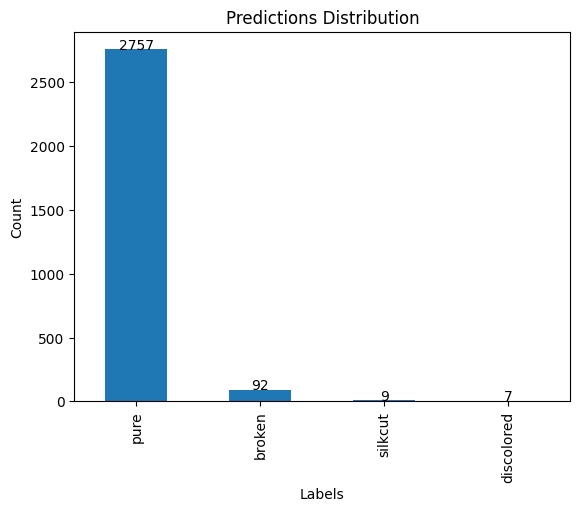

In [16]:
pred_class_hist(y_pred)

## Cross Validation to find Neighbor number

In [17]:
from sklearn.model_selection import KFold, cross_val_score

In [18]:
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=20)

num_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 25, 35, 50]

avg_accuracies = []

for neighbors in num_neighbors:
    # Create a KNN classifier with the current number of neighbors
    knn = KNeighborsClassifier(n_neighbors=neighbors)

    # Calculate the cross-validated accuracy for the current number of neighbors
    cv_accuracies = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
    print(cv_accuracies)
    # Compute the average accuracy across the folds
    avg_accuracy = np.mean(cv_accuracies)
    avg_accuracies.append(avg_accuracy)

    print(f"Neighbors: {neighbors}, Avg. Accuracy: {avg_accuracy:.4f}")

[0.43237347 0.44197208 0.4465299  0.4373636  0.43954605]
Neighbors: 1, Avg. Accuracy: 0.4396
[0.42670157 0.45855148 0.44827586 0.43867307 0.43037975]
Neighbors: 3, Avg. Accuracy: 0.4405
[0.42495637 0.45724258 0.44565692 0.43998254 0.41946748]
Neighbors: 5, Avg. Accuracy: 0.4375
[0.42146597 0.44502618 0.44565692 0.43212571 0.41510258]
Neighbors: 7, Avg. Accuracy: 0.4319
[0.42102967 0.44153578 0.43910956 0.42688782 0.41772152]
Neighbors: 9, Avg. Accuracy: 0.4293
[0.41535777 0.44022688 0.4373636  0.42077695 0.41684854]
Neighbors: 11, Avg. Accuracy: 0.4261
[0.41317627 0.43848168 0.43605412 0.42383239 0.41292012]
Neighbors: 13, Avg. Accuracy: 0.4249
[0.41317627 0.43630017 0.4325622  0.41990397 0.41161065]
Neighbors: 15, Avg. Accuracy: 0.4227
[0.40968586 0.43106457 0.43081624 0.41815801 0.4094282 ]
Neighbors: 17, Avg. Accuracy: 0.4198
[0.40968586 0.43106457 0.42994326 0.41422959 0.40986469]
Neighbors: 20, Avg. Accuracy: 0.4190
[0.40837696 0.43106457 0.42514186 0.41510258 0.40724574]
Neighbor

In [19]:
# Find the best number of neighbors based on the highest average accuracy
best_neighbors = num_neighbors[np.argmax(avg_accuracies)]
print(f"\nBest number of neighbors: {best_neighbors}")


Best number of neighbors: 3


## Retrain model with best hyper-parameter

In [20]:
knn = KNeighborsClassifier(n_neighbors=best_neighbors)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

      broken     0.5461    0.1607    0.2483       921
  discolored     0.2000    0.0276    0.0485       507
        pure     0.4293    0.9172    0.5849      1159
     silkcut     0.5208    0.0899    0.1534       278

    accuracy                         0.4363      2865
   macro avg     0.4241    0.2989    0.2588      2865
weighted avg     0.4352    0.4363    0.3399      2865



### discussion: 

After updating the n_neighbors hyperparameter to 3 the score is slightly better about .01 increase in accuracy. Which is insignificant, now I would like to try using PCA to reduce noise in the data and retest the KNN model. 

In [21]:
# recall shape of data: 
# print(pd.DataFrame(hog_features).shape) # (14322, 9216)

In [22]:
# Fit PCA to the data, then transform
from sklearn.decomposition import PCA
pca = PCA(n_components=1000) # 1000 for the sake of 
pca.fit(hog_features)
pca_hog_features = pca.transform(hog_features)

In [23]:
# check PCA variance explained
print(pca.explained_variance_[:10], "\nsum of variance in 10 features:", sum(pca.explained_variance_[:10]), 
      "\nTotal sum of 100 features:", sum(pca.explained_variance_[:100]),
       "sum of all 1000 features:", sum(pca.explained_variance_))
print(pca.explained_variance_ratio_[:10])

[2.62755129 2.5324198  2.42765479 2.34580587 1.41523289 1.36941635
 1.23688284 0.89049787 0.86741241 0.78017339] 
sum of variance in 10 features: 16.493047494747817 
Total sum of 100 features: 38.49146255614845 sum of all 1000 features: 68.7980899702306
[0.03171503 0.03056678 0.02930224 0.02831431 0.01708212 0.01652911
 0.0149294  0.01074847 0.01046983 0.00941684]


In [24]:
# Train Test Split for PCA data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_hog_features, labels, test_size=0.2, random_state=65)

# predict on same hyper-parameters and all data 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train_pca)
y_pred_pca = knn.predict(X_test_pca)
print(classification_report(y_test_pca, y_pred_pca, digits = 4))


              precision    recall  f1-score   support

      broken     0.5078    0.1769    0.2623       916
  discolored     0.2174    0.0288    0.0509       520
        pure     0.4317    0.9157    0.5868      1150
     silkcut     0.5526    0.0753    0.1325       279

    accuracy                         0.4366      2865
   macro avg     0.4274    0.2992    0.2581      2865
weighted avg     0.4289    0.4366    0.3416      2865



In [25]:
X_train_pca.shape

(11457, 1000)

In [26]:
# cross validation to find best number of folds and best number of PCA componenets
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=20)

num_neighbors = [3, 7, 9, 13, 20, 35, 50, 65, 90, 100]
num_pca_comp = [10, 15, 20, 25, 35, 50, 100, 250, 500, 1000]

# Initialize an empty dict to store the average accuracy for each number of neighbors and components
best_params = {'n_neighbors': None, 'n_components': None, 'accuracy': 0}

for neighbors in num_neighbors:
    for n_components in num_pca_comp:
        
        # Create a KNN classifier with the current number of neighbors
        knn = KNeighborsClassifier(n_neighbors=neighbors)

        # Calculate the cross-validated accuracy for the current number of neighbors and components
        cv_accuracies = cross_val_score(knn, X_train_pca[:, :n_components], y_train_pca, cv=kf, scoring='accuracy')
        
        # Compute the average accuracy across the folds
        avg_accuracy = np.mean(cv_accuracies)

        # Check if the current combination has better accuracy
        if avg_accuracy > best_params['accuracy']:
            best_params['n_neighbors'] = neighbors
            best_params['n_components'] = n_components
            best_params['accuracy'] = avg_accuracy

        print(f"Neighbors: {neighbors}, Components: {n_components}, Avg. Accuracy: {avg_accuracy:.4f}")

print(f"Best parameters: {best_params}")

Neighbors: 3, Components: 10, Avg. Accuracy: 0.4061
Neighbors: 3, Components: 15, Avg. Accuracy: 0.4199
Neighbors: 3, Components: 20, Avg. Accuracy: 0.4386
Neighbors: 3, Components: 25, Avg. Accuracy: 0.4463
Neighbors: 3, Components: 35, Avg. Accuracy: 0.4539
Neighbors: 3, Components: 50, Avg. Accuracy: 0.4562
Neighbors: 3, Components: 100, Avg. Accuracy: 0.4615
Neighbors: 3, Components: 250, Avg. Accuracy: 0.4573
Neighbors: 3, Components: 500, Avg. Accuracy: 0.4548
Neighbors: 3, Components: 1000, Avg. Accuracy: 0.4486
Neighbors: 7, Components: 10, Avg. Accuracy: 0.4349
Neighbors: 7, Components: 15, Avg. Accuracy: 0.4569
Neighbors: 7, Components: 20, Avg. Accuracy: 0.4705
Neighbors: 7, Components: 25, Avg. Accuracy: 0.4720
Neighbors: 7, Components: 35, Avg. Accuracy: 0.4827
Neighbors: 7, Components: 50, Avg. Accuracy: 0.4815
Neighbors: 7, Components: 100, Avg. Accuracy: 0.4782
Neighbors: 7, Components: 250, Avg. Accuracy: 0.4699
Neighbors: 7, Components: 500, Avg. Accuracy: 0.4561
Neig

In [27]:
print(f"Best parameters: {best_params}")

Best parameters: {'n_neighbors': 50, 'n_components': 35, 'accuracy': 0.5021401751904219}


In [28]:
# train model with best hyperparameters after cross validation grid search
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
knn.fit(X_train_pca[:, :best_params['n_components']], y_train_pca)
y_pred_pca = knn.predict(X_test_pca[:, :best_params['n_components']])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.6174    0.4651    0.5305       916
  discolored     0.5000    0.0135    0.0262       520
        pure     0.4822    0.8930    0.6262      1150
     silkcut     0.6129    0.0681    0.1226       279

    accuracy                         0.5162      2865
   macro avg     0.5531    0.3599    0.3264      2865
weighted avg     0.5414    0.5162    0.4377      2865



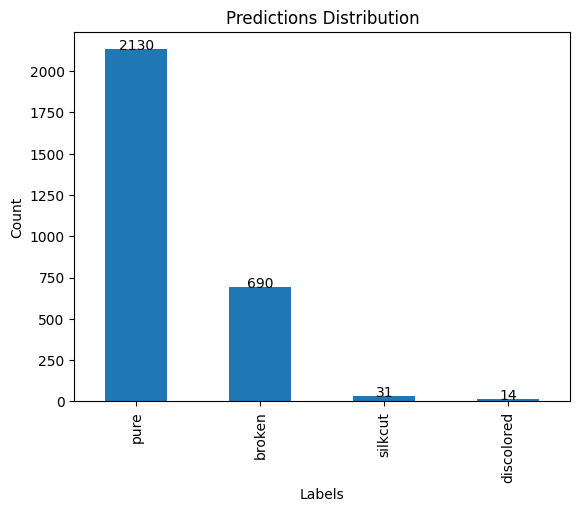

In [29]:
pred_class_hist(y_pred_pca)

We can see that with dimensionality reduction improved prediction accuracy significantly. The overall score has only gone up by ~7%, however, there are less 'pure' predictions by comparison, suggesting that noise was successfully reduced using PCA. Interestingly this reduction in noise changed the number of neighbors which is most performant for the KNN classifier. 

With the balance of the data clearly having some association with the performance of the KNN model I wonder if there is a possibility of using resampling to balance the data set in order to improve the KNN model further. 

I also am curious to see the performance of other methods in dimensionality reduction wrt to this task, as I believe reducing the noise within the HOG feature extraction is a key component in improving predictions with KNN, as we truly would expect neighboring points to begin to arise only when the most important differentiating features of each image are emphasized in their vector representation. 

At this point I still doubt the KNN model will be able to perform very well overall. If I could breach 60% accuracy I would be impressed using this model and I still expect other models to be more performant overall. 

##
## Image Classification: Random Forest using SIFT (scale invariant feature transform) 

In [30]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [31]:
img1 = croppedImages_grey[0]
print(type(img1))
print(img1.shape)

<class 'numpy.ndarray'>
(140, 140)


In [32]:
# convert images to uint8 format such that detectAndCompute can be used
croppedImages_grey_uint8 = [np.uint8(img * 255) for img in croppedImages_grey]

In [33]:
# Extract SIFT features
sift = cv2.SIFT_create()
sift_features = [sift.detectAndCompute(img, None)[1] for img in croppedImages_grey_uint8]

In [34]:
# inspect and understand sift_features
print(type(sift_features[1]), sift_features[1].shape)
print(len(sift_features))
#print(set([rep.shape for rep in sift_features]))
print(set(type(rep) for rep in sift_features))
print(set([rep.shape for rep in sift_features if isinstance(rep, np.ndarray)])) # gross to compare by string, using this function to compare types seems most natural 

typeStack = np.vstack(list(set([rep.shape for rep in sift_features if isinstance(rep, np.ndarray)])))
print(set(typeStack[:,1]))

# print(set([rep.shape for rep in sift_features if str(type(rep)) == 'np.ndarray' ]))
# print(str(type(sift_features[1]))) # <class 'numpy.ndarray'>

<class 'numpy.ndarray'> (6, 128)
14322
{<class 'numpy.ndarray'>, <class 'NoneType'>}
{(4, 128), (37, 128), (17, 128), (28, 128), (50, 128), (61, 128), (8, 128), (19, 128), (52, 128), (30, 128), (41, 128), (10, 128), (32, 128), (43, 128), (26, 128), (1, 128), (21, 128), (54, 128), (12, 128), (23, 128), (34, 128), (45, 128), (14, 128), (3, 128), (36, 128), (47, 128), (5, 128), (27, 128), (51, 128), (25, 128), (16, 128), (38, 128), (71, 128), (49, 128), (82, 128), (7, 128), (29, 128), (18, 128), (40, 128), (20, 128), (31, 128), (53, 128), (22, 128), (55, 128), (9, 128), (11, 128), (33, 128), (2, 128), (13, 128), (24, 128), (46, 128), (35, 128), (15, 128), (48, 128), (6, 128), (39, 128)}
{128}


In [35]:
# inspecting the contents of SIFT feature extraction: 
print([arr for arr in sift_features[:2]])

[array([[  1.,   4.,  16., ...,   0.,   0.,   2.],
       [  1.,   2.,  22., ...,   1.,   0.,   5.],
       [  1.,  17., 127., ...,  15.,  81.,  18.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   5.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  5.,  19.,   4., ...,   1.,   2.,   7.]], dtype=float32), array([[  3.,  28., 144.,   3.,   0.,   0.,   0.,   1.,   2., 144., 144.,
          1.,   0.,   0.,   0.,   0.,  10., 111.,  14.,   0.,   0.,   0.,
          0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   8.,
         17.,  50.,  10.,   9.,   9.,  22.,  24.,  42., 144.,  56.,  28.,
         23.,   5.,   1.,   1., 144., 144.,   6.,   2.,   1.,   0.,   0.,
          4.,  27.,  11.,   0.,   0.,   0.,   0.,   1.,   3.,   0.,   1.,
          7.,  34.,  42.,   6.,   6.,   1.,  82.,   9.,   2.,  34.,  39.,
          4.,   3.,  55., 144.,  23.,   0.,   1.,   1.,   0.,   0., 123.,
         38.,   1.,   0.,   0.,   0.,   0.,   0.,  13.,   2.,  14.,  11.,
    

In [36]:
# count none values, grab indices 
none_count = 0
none_idx = []
for idx, features in enumerate(sift_features):
    if features is None:
        none_count+=1
        none_idx.append(idx)
        
print(none_count) # 66 none values 
print(none_idx)

66
[81, 562, 822, 911, 1100, 1377, 1706, 1962, 2201, 2390, 2533, 2894, 3383, 3854, 3858, 4189, 4240, 4265, 4852, 5042, 5510, 5575, 5659, 6406, 6491, 6916, 6941, 7029, 7129, 7192, 7228, 7263, 7312, 7327, 7551, 7574, 7714, 8049, 8071, 8105, 8176, 8391, 8844, 9143, 9394, 9407, 9473, 10508, 10636, 10975, 11060, 11260, 11262, 11266, 11629, 11765, 12124, 12260, 12273, 12757, 12996, 13538, 13541, 14113, 14226, 14288]


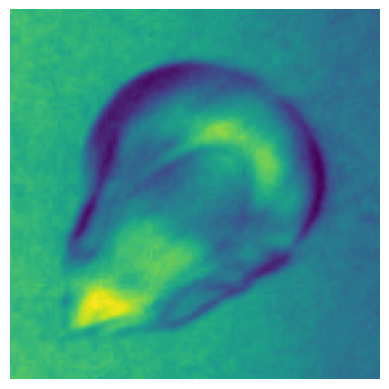

In [37]:
# inspect images causing issues: 
plt.imshow(croppedImages_grey[1100])  
plt.axis('off')
plt.show()

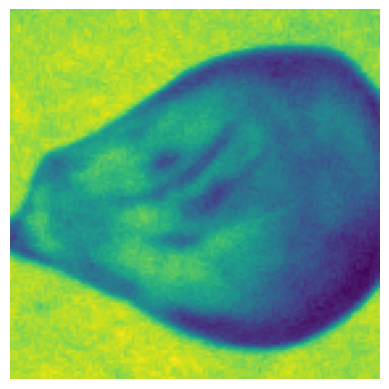

In [38]:
plt.imshow(croppedImages_grey_uint8[81])  
plt.axis('off')
plt.show()

The images causing issues aren't evidently different visually, and the fact they are in fact images means that there must be a more subtle explanation for the failure to generate SIFT features. I will remove them from the data set and train the model without them, as it is a small subset of the overall data which is having issue. 


In [39]:
# removing bad indices from sift_features
sift_features = [itm for idx, itm in enumerate(sift_features) if idx not in none_idx]

In [40]:
# Stack all feature vectors
all_features = np.vstack(sift_features)

# Create visual vocabulary using k-means clustering
k = 100  # Number of clusters (visual words)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(all_features)

# Generate histograms of visual words for each image
image_histograms = []
for feature in sift_features:
    histogram = np.zeros(k)
    clusters = kmeans.predict(feature)
    for cluster in clusters:
        histogram[cluster] += 1
    image_histograms.append(histogram)

c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [41]:
# inspedct image_histograms
print(type(image_histograms))
print(image_histograms[0])
for i in range(10):
    print(image_histograms[i])

<class 'list'>
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 2. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 2. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 2. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 2. 0. 1. 0. 0. 

In [42]:
# inspect kmeans clusters
print(type(kmeans.cluster_centers_))
print(kmeans.cluster_centers_.shape)
print([center.shape for center in kmeans.cluster_centers_])
for i in range(10):
    print(kmeans.cluster_centers_[i])

<class 'numpy.ndarray'>
(100, 128)
[(128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,), (128,)]
[  2.3792229    4.672699    27.97372     76.98311     50.641415
  15.678347     5.2759733    2.7271624   33.39673     69.10012
  76.92869     54.428055    22.819775

In [43]:
# update labels to remove bad indices from SIFT feature extraction 
forest_labels = [itm for idx, itm in enumerate(labels) if idx not in none_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(image_histograms, forest_labels, test_size=0.2, random_state=51)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=72)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)


In [44]:
# Evaluate the classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      broken       0.46      0.57      0.51       904
  discolored       0.39      0.19      0.26       472
        pure       0.61      0.77      0.68      1173
     silkcut       0.35      0.03      0.05       303

    accuracy                           0.53      2852
   macro avg       0.45      0.39      0.37      2852
weighted avg       0.50      0.53      0.49      2852



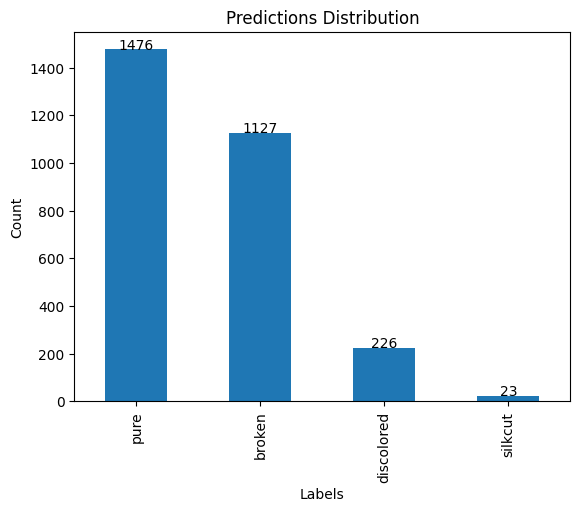

In [45]:
pred_class_hist(y_pred)

### Discussion of first RandomForest Performance: 

The Random Forest classifier is outperforming all versions of KNN tested thus far, but is still underwhelming at only .53 accuracy. Prediction spread is closer in relative distribution to the actual distribution which is good to see, thoug silkcut is still strongly underrepresented. 

Hyperparameter tuning for the SIFT feature extraction as well as the random forest model may yield better results. 

In [46]:
# Remove problem images from image set
croppedImages_grey_uint8_cleaned = [img for idx, img in enumerate(croppedImages_grey_uint8) if idx not in none_idx]

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# Define a custom transformer for SIFT feature extraction and visual words generation
class SIFTVisualWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nfeatures, contrastThreshold, edgeThreshold, n_clusters):
        self.nfeatures = nfeatures
        self.contrastThreshold = contrastThreshold
        self.edgeThreshold = edgeThreshold
        self.n_clusters = n_clusters
        
    def fit(self, X, y=None):
        self.sift = cv2.SIFT_create(nfeatures=self.nfeatures, contrastThreshold=self.contrastThreshold, edgeThreshold=self.edgeThreshold)
        sift_features = [self.sift.detectAndCompute(img, None)[1] for img in X]
        all_features = np.vstack(sift_features)
        
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=1)
        self.kmeans.fit(all_features)
        return self
        
    def transform(self, X):
        image_histograms = []
        for img in X:
            feature = self.sift.detectAndCompute(img, None)[1]
            histogram = np.zeros(self.n_clusters)
            clusters = self.kmeans.predict(feature)
            for cluster in clusters:
                histogram[cluster] += 1
            image_histograms.append(histogram)
        return image_histograms
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def get_params(self, deep=True):
        return {'nfeatures': self.nfeatures, 'contrastThreshold': self.contrastThreshold, 'edgeThreshold': self.edgeThreshold, 'n_clusters': self.n_clusters}

In [47]:
# Define the pipeline
pipeline = Pipeline([
    ('sift_visual_words', SIFTVisualWordsTransformer(nfeatures=0, contrastThreshold=0.04, edgeThreshold=10, n_clusters=100)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=72))
])

# Hyperparameters to search
param_grid = {
    'sift_visual_words__n_clusters': [50, 100, 200],
    'random_forest__n_estimators': [50, 100, 200],
}

    # 'sift_visual_words__nfeatures': [0, 50, 500],
    # 'sift_visual_words__contrastThreshold': [0.02, 0.06, 0.1],
    # 'sift_visual_words__edgeThreshold': [5, 10, 15],

In [48]:
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(croppedImages_grey_uint8_cleaned, forest_labels)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Evaluate on the test set
best_pipeline = grid_search

Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best parameters: {'random_forest__n_estimators': 200, 'sift_visual_words__n_clusters': 200}


In [59]:
print(grid_search.best_score_)
# looks like little to no improvement here... Not sure how to proceed given immense gridsearch time. Perhaps I could setup a clean architecture which allows for testing of other parameters more simply? 

0.5340207631874299


## HOG + Random Forest: 

In [ ]:
# split data, train model, make predictions
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(hog_features, labels, test_size=0.2, random_state=451)

In [ ]:
rf2 = RandomForestClassifier(n_estimators=1000, random_state=4)
rf2.fit(X_train_hog, y_train_hog)
y_pred_hog_rf2 = rf2.predict(X_test_hog)
print(classification_report(y_test_hog, y_pred_hog_rf2))

In [ ]:

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=510)

num_estimators = [100, 250, 500, 1000, 2000]
num_pca_comp = [10, 15, 20, 25, 35, 50, 100, 250, 500, 1000]

best_HP = {'num_estimators': 0, 'num_pca_comp': 0, 'accuracy': 0}

for est in num_estimators:
    for comp in num_pca_comp:
        rtc = RandomForestClassifier(n_estimators=est)
        crossVal_accuracies = cross_val_score(rtc, X_train_pca[:, :comp], y_train_pca, cv=kf, scoring='accuracy')
        
        print(f"For est: {est} and comp: {comp} accuracies:", crossVal_accuracies)
        avg_acc = np.mean(crossVal_accuracies)
        
        if avg_acc > best_HP['accuracy']:
            best_HP['accuracy'] = avg_acc
            best_HP['num_estimators'] = est
            best_HP['num_pca_comp'] = comp 
        
print(f"Best hyperparameters: {best_HP}")

STRATEGY FOR NEXT STEPS: 
PCA on HOG, and 1 other method of preprocessing which may influence the outcome, then try all on KNN with same hyperparameter set. See what the best result is afterwards. 
- PCA on HOG, 
- look into non-PCA other feature reduction method to eliminate noise 
- non-PCA on HOG
- run KNN on both with comprehensive search for best hyper parameters. 
- introduce 1 new model, (study lightly)
- 1 new feature extraction (study lightly)
- try all permutations of feature extraction to model prediciton now possible
- introduce 1 new model, (study lightly)
- 1 new feature extraction (study lightly)
- try all permutations of feature extraction to model prediciton now possible
- Draft final report explaining my process of exploring this problem space from an entry level of experience and share on best results and all results and why each is different as far as I can understand. 


STRATEGY 2: 

- Research Random Forest, SURF, SIFT. 
- Choose between SURF and SIFT
- Only test 2 models and 2 feature extractions for the project and final report. Should be plenty to report on in terms of technical details of each model and stages of testing and learning. 
- In the future if we want to push this experiment further to make for more impressive sharable content under my name (which honestly seems appealing) I can push the project further, imrpove the architecture of testing, and continue trying more models, tools, preprocessing tricks, etc, until I have reached some natural end point. Finally sharing my results in some compelling form on github would be great, as I could thus have a solid project to show some experience with these tools. 

IDEAS TO TRY: 
- rotating images into same orientation s.t. data is more fundamentally similar. (no data on orientatin means I would need a manual approach or some new tech)
- trying different pixel counts and degrees of zoom on images. 
- resampling to balance the data set 
- seeing if using multiple channels makes any difference. 
- making a testing function which takes in split data, and an optional number of parameters to test (lists of values) and a model which is named, thusly it would be easy to try out different combinations of preprocessing / feature extraction, as the function would allow data in to be tested against multiple models, best parameters to be found, and reporting of evaluation metrics and graphics to be generated. 
- Leaning towards SVM/Random Forest as the novel classifiers to try out. 
- 


### RESOURCES: 
- https://towardsdatascience.com/understanding-random-forest-58381e0602d2
- https://www.youtube.com/watch?v=wcqbiHonfbo&list=PL2zRqk16wsdqXEMpHrc4Qnb5rA1Cylrhx&index=13
-  ^^ link the accompanying series of videos, or all videos under the citation of this guys name and youtube channel 
- 



### NOTES: 
#### Random Forests: 
 - Bagging = bootstrap aggregation, important part of how random trees work. 
 - We need features that have at least some predictive power. After all, if we put garbage in then we will get garbage out.
 - The trees of the forest and more importantly their predictions need to be uncorrelated (or at least have low correlations with each other). While the algorithm itself via feature randomness tries to engineer these low correlations for us, the features we select and the hyper-parameters we choose will impact the ultimate correlations as well.
 - 